# MNIST with octopusal networks

If you haven't already, I suggest you to read [the description of octopusal networks](https://nbviewer.jupyter.org/github/marconunnari/octopusal_networks/blob/master/OctopusalNetworks.ipynb).

In this notebook we use octopusal networks to recognize handwritten digits contained in the [MINST database](https://en.wikipedia.org/wiki/MNIST_database).

To achieve these, the strategy that has proved most successful is to use the convolutional base of a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) to extract features from the images and then give these features to an octopusal network that will classify them.

This may seem cheating but I think that before that the information arrive to the mind it is processed by some filters in the senses or somewhere else. So the convolution base in this example would act as the sensory system.

At the end we get a result of 86% accuracy by training the model only on 500 training examples and without tuning very well the hyperparameters. The goal is just to show how an octopusal network can recognize patterns given some features.

## Convolution Neural Network

Here we train a simple convolutional neural network with keras that get to 99% of accuracy on the MNIST and then save the model to a file. Uncomment the last line to generate the file.

In [17]:
from keras import layers
from keras import models

def train_conv_nn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    from keras.datasets import mnist
    from keras.utils import to_categorical

    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1))
    train_images = train_images.astype('float32') / 255

    test_images = test_images.reshape((10000, 28, 28, 1))
    test_images = test_images.astype('float32') / 255

    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_images, train_labels, epochs=5, batch_size=64)
    model.save('./cnn_minst.h5')
    
#train_conv_nn()

## Features extraction

Here we take the convolutional base of the model trained (so without the densely connected layers) and feed it with the original images of the digits. Then we convert the features extracted in a clause 'where' usable by the octopusal network.

The main function here is 'extract_data' that returns an object where we store the train and test datasets in a useful fashion.

In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.datasets import mnist
from keras.models import load_model

np.set_printoptions(suppress=True)

model = load_model('./cnn_minst.h5')
layer_name = 'flatten_1'
conv_base = Model(inputs=model.input,
                             outputs=model.get_layer(layer_name).output)


def features_to_where(features, threshold):
    where = []
    for i in range(0, len(features)):
        value = features[i]
        if (value > threshold):
            where.append((0, i))
    return where


def show_image(image, label):
    plt.title(f'Image: {label}')
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()


class MnistDataItem:
    def __init__(self, image, label, where):
        self.image = image
        self.label = label
        self.where = where


class MnistDataSet:
    def __init__(self, size, images, labels, wheres):
        self.size = size
        self.images = images
        self.labels = labels
        self.wheres = wheres

    def get_item(self, index):
        return MnistDataItem(
            self.images[index],
            self.labels[index],
            self.wheres[index]
        )


class MnistData:
    def __init__(self, train, test):
        self.train = train
        self.test = test


def extract_features(images, labels, size, threshold):
    images_mod = images.reshape((images.shape[0], 28, 28, 1)).astype('float32') / 255
    wheres = []
    for index in range(0, size):
        label = labels[index]
        image = images[index]

        image_mod = images_mod[index]

        features = conv_base.predict(image_mod[None, :, :, :])
        features = features * 100
        features = features.astype(int)
        features = features.reshape((576))

        where = features_to_where(features, threshold)
        wheres.append(where)
    return MnistDataSet(size, images[:size], labels[:size], wheres)

    
def extract_data(size_train, size_test):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
    train = extract_features(train_images, train_labels, size_train, 50)
    test = extract_features(test_images, test_labels, size_test, 50)
    return MnistData(train, test)

## Octopusal Network

To classify the MNIST we import the octopusal networks and we introduce three new features: Freezing, Custom emojis and Emispheres.

In [19]:
from basic_octopusal_networks import *

### Freezing

We add the concept of freezing that prevent the soreness of tentacles to increase if we set the property `freeze_connections` to `True`. This is useful in the testing stage because we don't want the beach to learn anymore. So when `freeze_connections` is `True` the beach can't form new connections and it will only apply the knowledge acquired in the past.

In [20]:
class TentacleWithFreezing(TentacleWithSoreness):

    freeze_connections = False

    def __init__(self, id, owner, connected):
        super().__init__(id, owner, connected)

    def shock(self):
        if self.connected.awake:
            if not TentacleWithFreezing.freeze_connections:
                self.soreness += 1
        else:
            self.connected.shocked(self.soreness)

In [21]:
class BeachWithFreezing(BeachWithListeners):
    
    def __init__(self, width, height, shocks_threshold=80,
                 smell_threshold=50, tiredness_threshold=5, recovery_threshold=5):
        super().__init__(width, height, shocks_threshold, smell_threshold,
                         tiredness_threshold, recovery_threshold)

    def create_tentacle(self, id, owner, connected):
        return TentacleWithFreezing(id=id, owner=owner, connected=connected)

    def animate(self, where=None, iterations=10, show=True, freeze_connections=False):
        TentacleWithFreezing.freeze_connections = freeze_connections
        super().animate(where, iterations, show)

### Custom emojis

We add the possibility to change the emoji when the octopuses are awake. So when we print the beach instead of seeing 💡 for the octopuses awake we'll see the custom emoji. We add also a method on the beach to customize the emoji for more octopuses at the same time.

In [22]:
class OctopusWithCustomEmoji(OctopusWithListeners):

    def __init__(self, id, environment):
        super().__init__(id, environment)
        self.emoji = '💡'

    def set_emoji(self, emoji):
        self.emoji = emoji

In [23]:
class BeachWithCustomEmojis(BeachWithFreezing):

    def __init__(self, width, height, shocks_threshold=80,
                 smell_threshold=50, tiredness_threshold=5, recovery_threshold=5):
        super().__init__(width, height, shocks_threshold, smell_threshold,
                         tiredness_threshold, recovery_threshold)

    def create_octopus(self, id):
        return OctopusWithCustomEmoji(id=id, environment=self)

    def set_emoji(self, where, emoji):
        for x, y in where:
            octopus = self.get(x, y)
            octopus.set_emoji(emoji)

    def __str__(self):
        result = '\n'
        for x in range(0, self.height):
            for y in range(0, self.width):
                octopus = self.octopuses[x * self.width + y]
                result += octopus.emoji if octopus.awake else '🐙'
            result += '\n'
        return result

### Hemispheres

Here we introduce the BeachWithHemispheres. In this class we don't connect the octopuses neighbours, but we divide the beach in two parts and we connect each octopus of the first part to each octopus on the other part. We also change the method `__str__` to show better this division adding a row of 🔗(link emojis) that divides the two hemispheres.

In [24]:
class BeachWithHemispheres(BeachWithCustomEmojis):

    def __init__(self, width, height, shocks_threshold=80,
                 smell_threshold=50, tiredness_threshold=5, recovery_threshold=5):
        super().__init__(width, height, shocks_threshold, smell_threshold,
                         tiredness_threshold, recovery_threshold)
        self.divide_hemispheres()
        self.connect_hemispheres()

    def connect_neighbours(self):
        pass

    def divide_hemispheres(self):
        half_row = self.height // 2
        half_index = half_row * self.width
        self.hemisphere1 = self.octopuses[:half_index]
        self.hemisphere2 = self.octopuses[half_index:]

    def connect_hemispheres(self):
        i = 0
        for octopus1 in self.hemisphere1:
            for octopus2 in self.hemisphere2:
                tentacle = self.create_tentacle(id=i, owner=octopus1, connected=octopus2)
                i += 1

    def __str__(self):
        result = '\n'
        max_width = self.width if self.width < 40 else 40
        counter = 1
        half_row = self.height // 2
        for x in range(0, self.height):
            if x == half_row:
                result += '\n'
                result += '🔗' * max_width
                result += '\n'
                counter = 1
            for y in range(0, self.width):
                octopus = self.octopuses[x * self.width + y]
                result += octopus.emoji if octopus.awake else '🐙'
                counter += 1
                if counter % (max_width + 1) == 0:
                    counter = 1
                    result += '\n'
        result += '\n'
        return result

## Training stage

To recognize the digits we build a beach with two rows. The first row is the first hemisphere on which we'll show the features. The second row is the second hemisphere where we assign the first 50 octopuses to the recognition of the digit zero, the second 50 octopuses to the recognition of the digit two and so on. To show this better we change some emojis so that the octopuses of the group dedicated at the digit one when awake will print 1️⃣ and the same for the other digits.

So for each training example we activate the beach with the features of the digit and the corresponding zone on the second hemisphere. In this way we connect the inputs with the expected outputs.

Eventually we attach a listener to each zone of the second hemisphere that will determine the prediction by detecting which digit pattern was awakened first.

In [39]:
import time
from progress_bar import ProgressBar

def create_mnist_beach():
    beach = BeachWithHemispheres(
        width=576, height=2,
        shocks_threshold=150000,
        tiredness_threshold=50,
        smell_threshold=200,
    )

    second_row = [(1, y) for y in range(0, 576)]
    zero = second_row[0:50]
    one = second_row[50:100]
    two = second_row[100:150]
    three = second_row[150:200]
    four = second_row[200:250]
    five = second_row[250:300]
    six = second_row[300:350]
    seven = second_row[350:400]
    eight = second_row[400:450]
    nine = second_row[450:500]
    digits = [zero, one, two, three, four, five, six, seven, eight, nine]

    beach.set_emoji(digits[0], '0️⃣')
    beach.set_emoji(digits[1], '1️⃣')
    beach.set_emoji(digits[2], '2️⃣')
    beach.set_emoji(digits[3], '3️⃣')
    beach.set_emoji(digits[4], '4️⃣')
    beach.set_emoji(digits[5], '5️⃣')
    beach.set_emoji(digits[6], '6️⃣')
    beach.set_emoji(digits[7], '7️⃣')
    beach.set_emoji(digits[8], '8️⃣')
    beach.set_emoji(digits[9], '9️⃣')
    
    return (beach, digits)

You can see in the next example that in the first emisphere of the beach (at the top) we have the octopuses awake that corresponds to the features extracted by the convolutional base and the in the second emisphere the group dedicated to the digit 5 awakened.

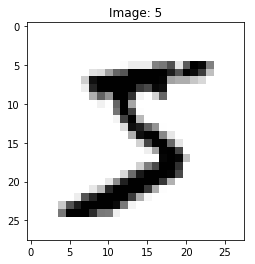

Start

🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙💡🐙🐙🐙🐙
🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙💡💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡🐙💡🐙🐙💡🐙💡🐙🐙
🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙
🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙
🐙🐙🐙💡💡💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙💡💡🐙🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙
💡🐙💡🐙🐙🐙💡🐙🐙💡💡💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡
🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡
🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙💡💡🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙
🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡🐙💡💡💡
🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣5️⃣
5️⃣5️⃣5️⃣5️⃣5️

In [40]:
mnist_data = extract_data(10, 10)
beach, digits = create_mnist_beach()

def show_example(beach, digits, index):
    item = mnist_data.train.get_item(index)
    show_image(item.image, item.label)
    digit = digits[item.label]
    beach.animate(item.where + digit, iterations=0, show=True)
    beach.night(show=False)

show_example(beach, digits, 0)

In [27]:
# extract train and test datasets
mnist_data = extract_data(500, 250)

# create beach
beach, digits = create_mnist_beach()

# train the network
dataset = mnist_data.train
print(f"Training examples: {dataset.size}")
pb = ProgressBar(dataset.size)
time_start = time.time()
for index in range(0, dataset.size):
    item = dataset.get_item(index)
    digit = digits[item.label]
    beach.animate(item.where + digit, iterations=10, show=False)
    beach.night(show=False)
    pb += 1
time_elapsed = time.time() - time_start
print(f" Time elapsed: {time_elapsed:.2f}s")
del pb

Training examples: 500
  100% [=================================================================] Time elapsed: 336.67s



Next we create and attach the listeners. We create a listener for each digit, the listeners share the class variable `winner` that will store the prediction given.

In [28]:
class DigitListener():

    threshold = 50
    winner = None

    def __init__(self, digit):
        self.digit = digit
        self.threshold = DigitListener.threshold

    def reset(self):
        DigitListener.winner = None
        self.threshold = DigitListener.threshold

    def fire(self, octopus):
        if octopus.awake:
            self.threshold -= 1
        if (self.threshold == 0):
            if DigitListener.winner == None:
                DigitListener.winner = self.digit
            self.threshold = DigitListener.threshold

for i, digit in enumerate(digits):
    beach.attach_listener(digit, DigitListener(i))

## Prediction

The function `predict` animate the beach with the features corresponding to a test digit and then it sees which digit is stored in the class variable `DigitListener.winner`, that is the prediction given by the octopusal network.

In [33]:
def predict(index, dataset, show=False):
    item = dataset.get_item(index)
    label = item.label
    if show: show_image(item.image, item.label)
    beach.animate(item.where, iterations=10, show=show, freeze_connections=True)
    winner = DigitListener.winner
    beach.night()
    return winner == label

In the next example we get a correct prediction. You can see how at the sixth iteration the group of octopuses in charge to recognize the digit zero wake up.

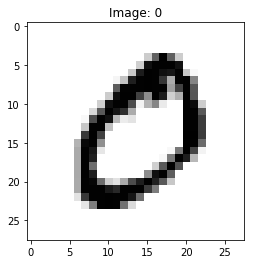

Start

🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙💡🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙💡
🐙🐙🐙🐙💡💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙💡💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙💡🐙🐙💡🐙🐙💡
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙
💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙
🐙💡🐙🐙💡💡💡💡🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡💡🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡💡🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙
🐙🐙💡💡🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙
🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
💡🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡💡🐙🐙💡
🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙

Iteration 6 - smell: 161

🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙💡🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙💡
🐙🐙🐙🐙💡💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙💡🐙🐙🐙💡🐙🐙💡💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙💡🐙🐙💡🐙🐙💡
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙
💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙
🐙💡🐙🐙💡💡💡💡🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡💡🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡💡🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙
🐙🐙💡💡🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙
🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
💡🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡💡🐙🐙💡
🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗
0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣
0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣0️⃣🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙

In [37]:
correct = predict(1, mnist_data.train, show=True)

In the next example we get a wrong prediction. You can see how at the sixth iteration the group of octopuses in charge to recognize the digit three wakes up but the correct digit is five. At iteration 7 wakes up also the group corresponding to the 5 but it's late because the prediction given is the first one.

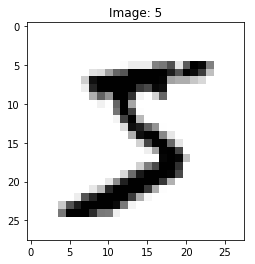

Start

🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙💡🐙🐙🐙🐙
🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙💡💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡🐙💡🐙🐙💡🐙💡🐙🐙
🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙
🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙
🐙🐙🐙💡💡💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙💡💡🐙🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙
💡🐙💡🐙🐙🐙💡🐙🐙💡💡💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡
🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡
🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙💡💡🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙
🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡🐙💡💡💡
🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙

Iteration 6 - smell: 166

🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙💡🐙🐙🐙🐙
🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙
🐙🐙💡💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙🐙💡💡🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡💡🐙💡🐙🐙💡🐙💡🐙🐙
🐙🐙🐙🐙💡🐙💡🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙
🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙
🐙🐙🐙💡💡💡🐙🐙💡🐙🐙🐙🐙🐙🐙🐙💡🐙💡🐙🐙💡💡🐙🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙💡🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙
💡🐙💡🐙🐙🐙💡🐙🐙💡💡💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡💡
🐙💡🐙🐙💡💡🐙🐙💡🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙💡🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡
🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙🐙🐙🐙🐙🐙💡🐙🐙🐙💡🐙💡💡🐙🐙🐙🐙💡💡🐙💡🐙🐙🐙🐙💡💡🐙🐙
🐙🐙🐙🐙🐙💡💡💡🐙🐙🐙💡🐙💡💡💡
🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗🔗
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣
3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣3️⃣
🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙🐙

In [38]:
correct = predict(0, mnist_data.train, show=True)

In the last cell we iterate over 250 test digits and calculate how many predictions are correct.

In [36]:
import time
from progress_bar import ProgressBar

correct = 0

start = 0
count = 250

print(f"Test samples: {count}\n")

pb = ProgressBar(count)
time_start = time.time()

for i in range(start, start + count):
    result = predict(i, mnist_data.test, show=False)
    if result == True:
        correct += 1
    pb += 1

time_elapsed = time.time() - time_start
print(f" Time elapsed: {time_elapsed:.2f}s")
del pb

print(f"Correct: {correct / count * 100:.2f}%")

Test samples: 250

  100% [=================================================================] Time elapsed: 183.35s

Correct: 86.40%


## Conclusions

I don't know if the use of the convolutional base has the greater part of the merit but I think that it's quite a good result anyway. The algorithm is still not optimized but seems to me that it has good perception skills. In addition to perception it has also other qualities as seen in the [previous notebook](https://nbviewer.jupyter.org/github/marconunnari/octopusal_networks/blob/master/OctopusalNetworks.ipynb).


If you have feedbacks or ideas feel free to contact me at hello@marconunnari.com

<p style="text-align: right"><i>Marco Nunnari<br>May 2018</i></p>